Time Series Analysis - AirPassengers Data
https://builtin.com/data-science/time-series-python

Across industries, organizations commonly use time series data, which means any information collected over a regular interval of time, in their operations. Examples include daily stock prices, energy consumption rates, social media engagement metrics and retail demand, among others. Analyzing time series data yields insights like trends, seasonal patterns and forecasts into future events that can help generate profits. 

When analyzing time series data, you should undertake a number of steps. First, you need to check for stationarity and autocorrelation. Stationarity is a way to measure if the data has structural patterns like seasonal trends. Autocorrelation occurs when future values in a time series linearly depend on past values. You need to check for both of these in time series data because they’re assumptions that are made by many widely used methods in time series analysis. For example, the autoregressive integrated moving average (ARIMA) method for forecasting time series assumes stationarity. Further, linear regression for time series forecasting assumes that the data has no autocorrelation. Before conducting these processes, then, you need to know if the data is viable for the analysis.

During a time series analysis in Python, you also need to perform trend decomposition and forecast future values. Decomposition allows you to visualize trends in your data, which is a great way to clearly explain their behavior. Finally, forecasting allows you to anticipate future events that can aid in decision making. You can use many different techniques for time series forecasting, but here, we will discuss the autoregressive integrated moving average (ARIMA).

In [3]:
import pandas as pd

In [4]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv


In [24]:
import io
df = pd.read_csv(io.BytesIO(uploaded['AirPassengers.csv']))

In [25]:
print(df.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


In [26]:
# convert the month column into a datetime object. This will allow it to programmatically pull time values like the year or month for each record.
# this process automatically inserts the first day of each month, which is basically a dummy value since we have no daily passenger data
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
print(df.head())

       Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121


In [27]:
# convert the month column to an index. This will allow us to more easily work with some of the packages 
df.index = df['Month']
del df['Month']
print(df.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns 

Text(0, 0.5, 'Number of Passengers')

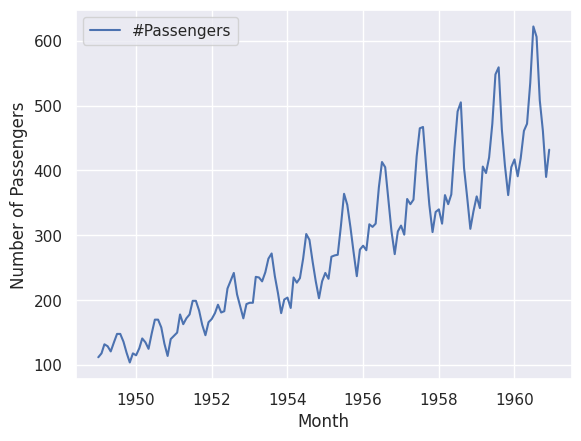

In [28]:
sns.lineplot(df)
plt.ylabel("Number of Passengers")

Stationarity is a key part of time series analysis. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. You should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

Null Hypothesis - There is no stationarity

Alternative Hyp - There is stationarity

We will use the Dickey Fuller test to check for stationarity in our data. This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity.

These values allow us to test the degree to which present values change with past values. If there is no stationarity in the data set, a change in present values will not cause a significant change in past values.

In [29]:
# Let’s test for stationarity in our airline passenger data. To start, let’s calculate a seven-month rolling mean
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()

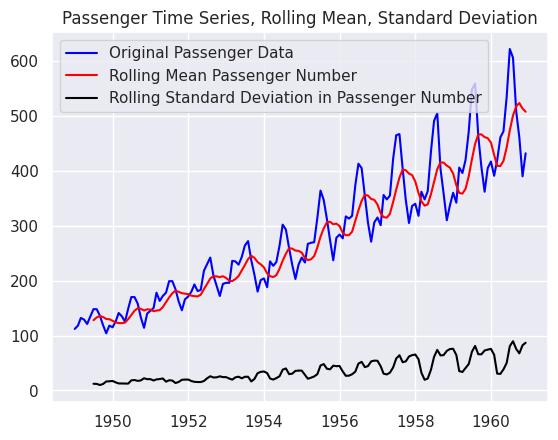

In [30]:
plt.plot(df, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [13]:
# import the augmented Dickey-Fuller test from the statsmodels package
from statsmodels.tsa.stattools import adfuller

In [31]:
# let’s pass our data frame into the adfuller method. 
# Here, we specify the autolag parameter as “AIC,” which means that the lag is chosen to minimize the information criterion
adft = adfuller(df,autolag="AIC")

In [32]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']], 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                           "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)
# our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. 
# p value greater than .05, accept the null hypothesis
# We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the number of passengers.

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


**Autocorrelation**
Checking time series data for autocorrelation in Python is another important part of the analytic process. This is a measure of how correlated time series data is at a given point in time with past values, which has huge implications across many industries. For example, if our passenger data has strong autocorrelation, we can assume that high passenger numbers today suggest a strong likelihood that they will be high tomorrow as well.

In [33]:
# The Pandas data frame has an autocorrelation method that we can use to calculate the autocorrelation in our passenger data
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.9601946480498523


In [34]:
# let’s try three, six and nine months:
# even with a nine-month lag, the data is highly autocorrelated. 

autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.837394765081794
Six Month Lag:  0.7839187959206183
Nine Month Lag:  0.8278519011167601


Decomposition

Trend decomposition is another useful way to visualize the trends in time series data

In [35]:
# import seasonal_decompose from the statsmodels package:
from statsmodels.tsa.seasonal import seasonal_decompose

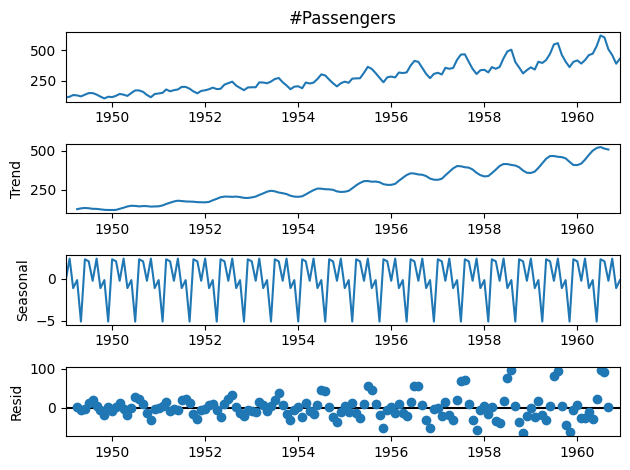

In [19]:
# let’s pass our data frame into the seasonal_decompose method and plot the result:
decompose = seasonal_decompose(df['#Passengers'],model='additive', period=7)
decompose.plot()
plt.show()

# we can clearly see the increasing trend in number of passengers and the seasonality patterns in the rise and fall in values each year.

Forecasting

Time series forecasting allows us to predict future values in a time series given current and past data. Here, we will use the ARIMA method to forecast the number of passengers, which allows us to forecast future values in terms of a linear combination of past values. We will use the auto_arima package, which will allow us to forgo the time consuming process of hyperparameter tuning.

In [37]:
df.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

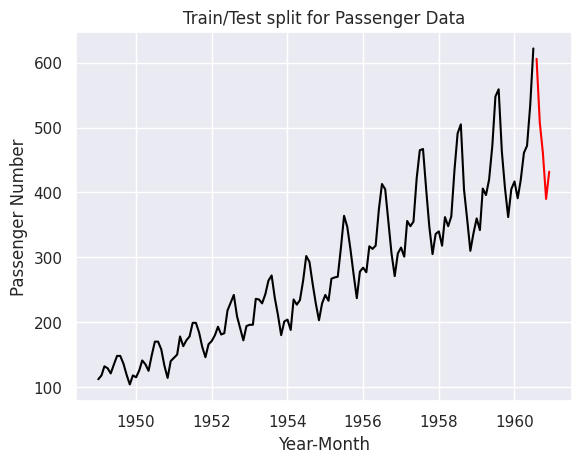

In [40]:
# let’s split our data for training and testing and visualize the split:
train = df[df.index < pd.to_datetime("1960-08", format='%Y-%m')]
test = df[df.index >= pd.to_datetime("1960-08", format='%Y-%m')]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
# The black line corresponds to our training data and the red line corresponds to our test data.

In [42]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.0 MB/s eta 0:00:00


In [43]:
#Let’s import auto_arima from the pdmarima package, train our model and generate predictions:

from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

In [46]:
forecast

Prediction
Month                 
1960-08-01  609.537778
1960-09-01  569.573016
1960-10-01  524.517117
1960-11-01  483.041402
1960-12-01  480.302284

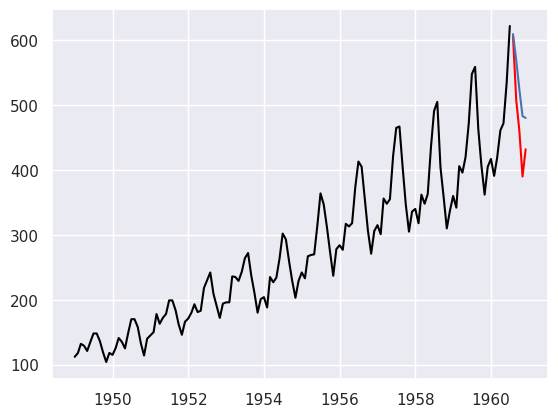

In [44]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast)
# Our predictions are shown in blue and the actual values are shown in red.

In [45]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  61.36446753530628
